# Setup

In [ ]:
# Install YOLO & CLIP
!pip install ultralytics > /dev/null
!pip install git+https://github.com/openai/CLIP.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-r0qye9l9


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from torchvision.io import read_image

from pretrained_models_features_extractors import make_extractor, _EXTRACTOR_REGISTRY

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Available extractors:", list(_EXTRACTOR_REGISTRY.keys()))

Device: cuda
Available extractors: ['resnet50', 'resnext50_32x4d', 'densenet121', 'efficientnet_b0', 'dinov2_vits', 'maskrcnn', 'yolo', 'clip']


TO BE USED EVERYTIME THE .py FILES CHANGES IN RUNTIME

In [ ]:
# Hot-reload modules and rebind the imported names
import importlib

import pretrained_models_features_extractors as pmfe
pmfe = importlib.reload(pmfe)
from pretrained_models_features_extractors import *

print("Reloaded:", pmfe.__name__)

Reloaded: pretrained_models_features_extractors


Dataset download

In [ ]:
# CUHK03 dataset download
!git clone https://github.com/manideep2510/CUHK03_dataset.git

Cloning into 'CUHK03_dataset'...
remote: Enumerating objects: 33345, done.
remote: Total 33345 (delta 0), reused 0 (delta 0), pack-reused 33345 (from 1)
Receiving objects: 100% (33345/33345), 336.68 MiB | 36.60 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (35659/35659), done.


 Load validation dataset (images)

In [ ]:
CUHK03_DATASET = "./CUHK03_dataset/detected/"
CUHK03_VAL_DIR = CUHK03_DATASET + "/val_resized"

# scan all filenames to get person IDs
all_files = [f for f in os.listdir(CUHK03_VAL_DIR) if f.lower().endswith(".jpg")]
all_pids = [f.split("_")[0] for f in all_files]
unique_pids = sorted(set(all_pids))[:10]  # pick first 10

print("Selected person IDs:", unique_pids)

images, labels = [], []
counts = {pid: 0 for pid in unique_pids}  # how many images per person

for fname in sorted(all_files):
    pid = fname.split("_")[0]
    if pid in unique_pids and counts[pid] < 5:
        img = read_image(os.path.join(CUHK03_VAL_DIR, fname)).float() / 255.0
        images.append(img.unsqueeze(0))
        labels.append(pid)
        counts[pid] += 1

images = torch.cat(images, dim=0).to(device)
labels = np.array(labels)

print("Final tensor shape:", images.shape)
print("Label distribution:", {pid: list(labels).count(pid) for pid in unique_pids})

Selected person IDs: ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
Final tensor shape: torch.Size([50, 3, 160, 60])
Label distribution: {'0000': 5, '0001': 5, '0002': 5, '0003': 5, '0004': 5, '0005': 5, '0006': 5, '0007': 5, '0008': 5, '0009': 5}


# t-SNE

In [ ]:
def extract_features_in_batches(extractor, images, batch_size=8, device="cuda"):
    feats = []
    extractor = extractor.to(device).eval()
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            out = extractor(batch).cpu()  # keep GPU clean
            feats.append(out)
            del batch, out
            torch.cuda.empty_cache()
    return torch.cat(feats, dim=0).numpy()


def tsne_for_extractors(extractor_names, images, labels, device, ncols=3, out_dir="outputs", out_file="tsne_extractors.png"):
    le = LabelEncoder()
    label_ids = le.fit_transform(labels)

    n_extractors = len(extractor_names)
    nrows = int(np.ceil(n_extractors / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()

    for i, extractor_name in enumerate(extractor_names):
        print(f"Extracting features with {extractor_name}...")
        extractor = make_extractor(extractor_name, device)

        feats = extract_features_in_batches(extractor, images,
                                            batch_size=8,
                                            device=device)

        tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42)
        reduced = tsne.fit_transform(feats)

        axes[i].scatter(
            reduced[:,0], reduced[:,1],
            c=label_ids, cmap="tab10", s=15
        )
        axes[i].set_title(extractor_name, fontsize=12)
        axes[i].set_xticks([]); axes[i].set_yticks([])

    # remove unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle("t-SNE of CUHK03 (first 5 persons) across extractors", fontsize=16)
    plt.tight_layout()

    # --- Save to file ---
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, out_file)
    fig.savefig(out_path, dpi=150)
    print(f"Saved t-SNE plot to: {out_path}")

    plt.show()


Try all extractors

Extractors:  ['resnet50', 'resnext50_32x4d', 'densenet121', 'efficientnet_b0', 'dinov2_vits', 'maskrcnn', 'yolo', 'clip']
Extracting features with resnet50...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Extracting features with resnext50_32x4d...
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 167MB/s]


Extracting features with densenet121...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 174MB/s]


Extracting features with efficientnet_b0...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 162MB/s]


Extracting features with dinov2_vits...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Extracting features with maskrcnn...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


100%|██████████| 177M/177M [00:01<00:00, 175MB/s]


Extracting features with yolo...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Extracting features with clip...


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 154MiB/s]


Saved t-SNE plot to: plots/tsne_extractors.png


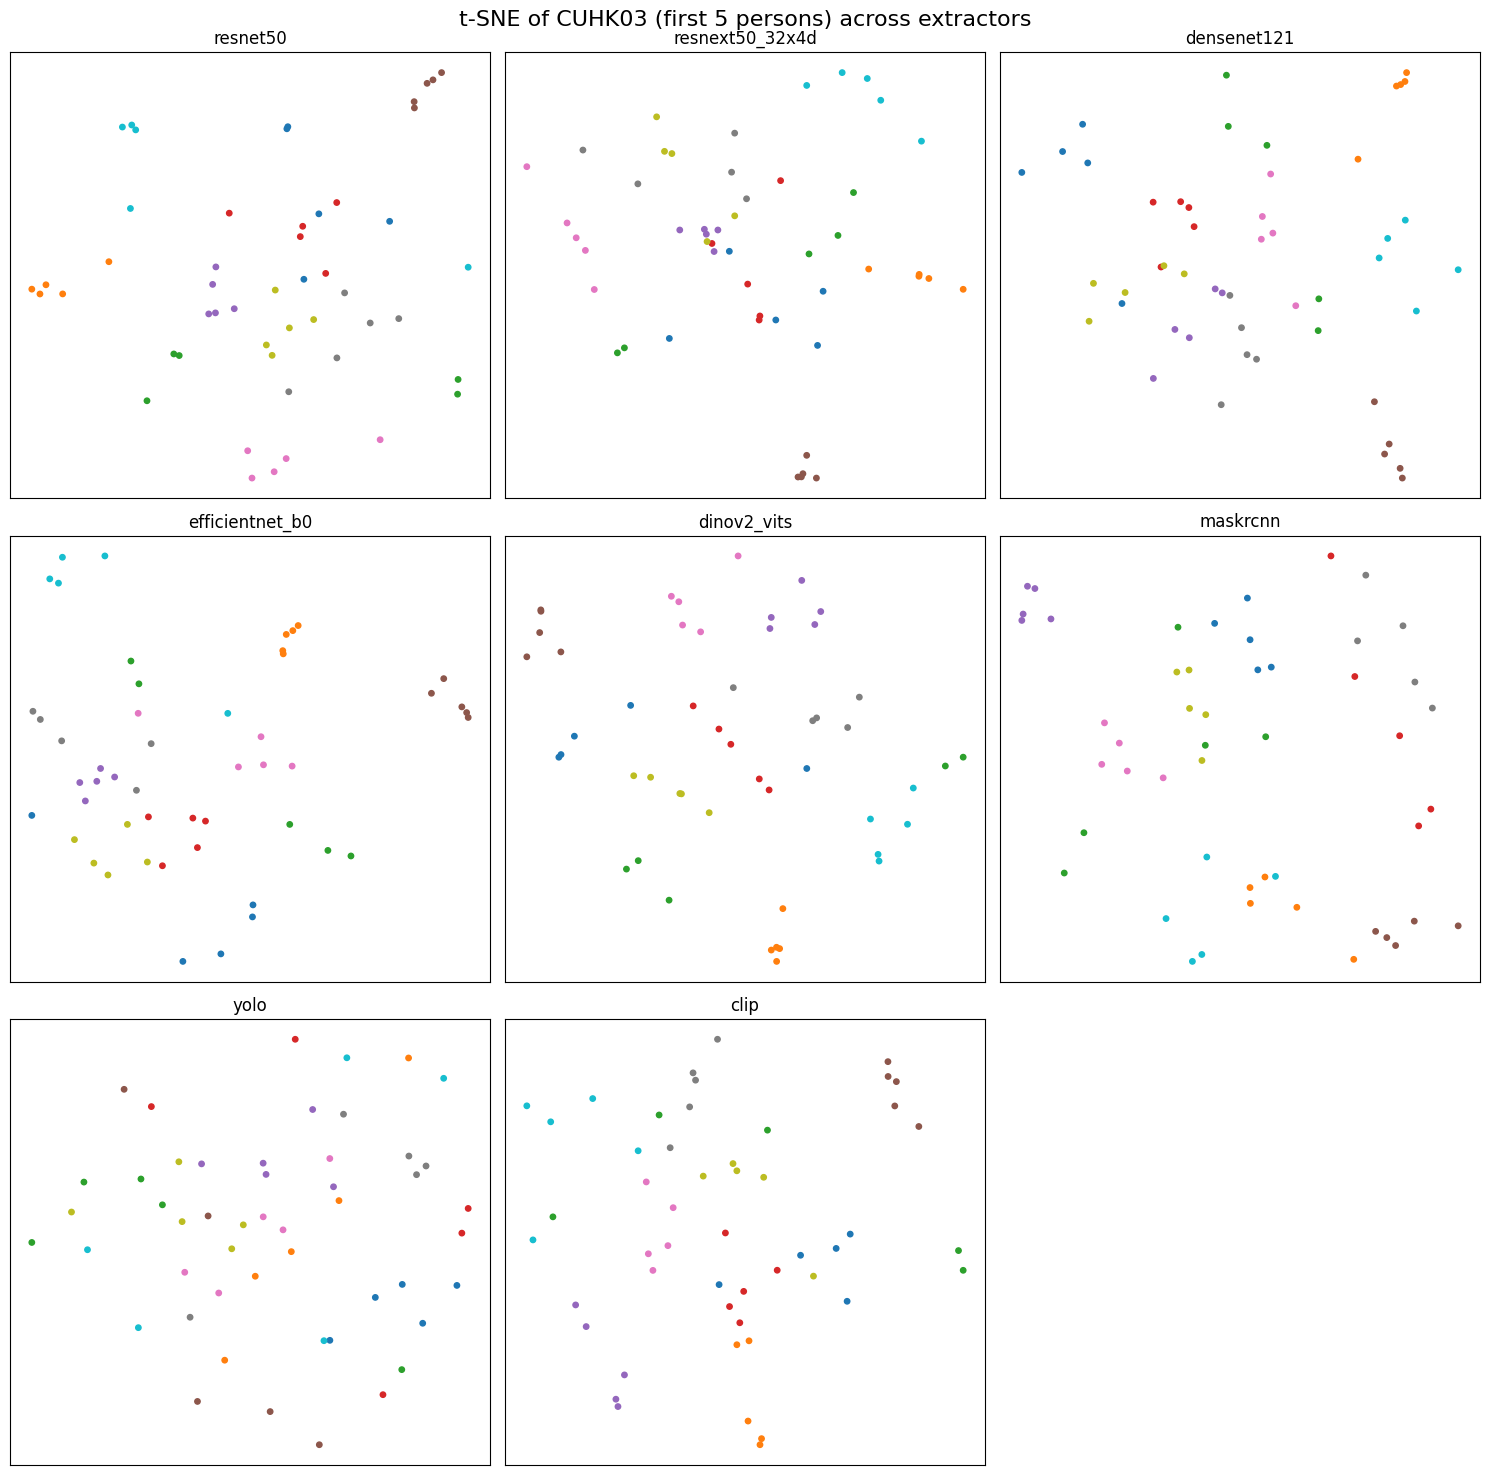

In [ ]:
extractor_names = list(_EXTRACTOR_REGISTRY.keys())
print("Extractors: ", extractor_names)
tsne_for_extractors(extractor_names, images, labels, device, ncols=3)